# VALUE AT RISK THROUGH MONTECARLO SIMULATIONS

In [3]:
import yfinance as yf
import pandas as pd

tickers = ['HDFCBANK.NS', 'SBIN.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'AXISBANK.NS']

data = yf.download(tickers, period= '3y')['Close']
data = data.dropna()

print(data.head())

/var/folders/70/13frzt6s3qv7gcdnbf2914xm0000gn/T/ipykernel_3698/482825688.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period= '3y')['Close']
[*********************100%***********************]  5 of 5 completed

Ticker      AXISBANK.NS  HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS     SBIN.NS
Date                                                                        
2022-12-26   926.246277   784.038818    871.620850   1807.989624  564.718445
2022-12-27   929.737000   784.832764    878.890869   1815.317017  569.258118
2022-12-28   922.256836   784.207214    877.231873   1814.519409  568.454224
2022-12-29   932.080750   789.740662    886.112061   1813.173584  578.621216
2022-12-30   931.282837   783.413208    869.327576   1821.647583  580.418213


In [ ]:
import numpy as np

log_returns = np.log(data /data.shift(1)).dropna()
print(log_returns.describe())


Ticker  AXISBANK.NS  HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS     SBIN.NS
count    742.000000   742.000000    742.000000    742.000000  742.000000
mean       0.000380     0.000317      0.000590      0.000242    0.000724
std        0.013625     0.011679      0.011139      0.013389    0.014750
min       -0.078719    -0.088130     -0.079407     -0.115097   -0.155532
25%       -0.007064    -0.005402     -0.004958     -0.006603   -0.006572
50%        0.000183     0.000650      0.000534      0.000267    0.000838
75%        0.007475     0.006520      0.006134      0.006951    0.007861
max        0.058229     0.045247      0.046083      0.088068    0.086806


In [ ]:
covariance_matrix = log_returns.cov()
try:
    L = np.linalg.cholesky(covariance_matrix)
    print(L)
except np.linalg.LinAlgError:
    print("Matrix not positive definite.")
    

[[0.01362513 0.         0.         0.         0.        ]
 [0.00484768 0.01062518 0.         0.         0.        ]
 [0.00587519 0.00296072 0.00898902 0.         0.        ]
 [0.00446058 0.00354455 0.00282601 0.01178216 0.        ]
 [0.00704117 0.00256981 0.00269808 0.00141824 0.01233282]]


In [18]:
import matplotlib.pyplot as plt

simulations = 10000
initial = 1000000 # Rupees 10 lakhs
weights = np.array([0.42,0.09,0.32,0.07,0.1])
mean_returns = log_returns.mean()

sim_returns = []

for i in range(simulations):
    Z = np.random.normal(size= len(tickers))
    correlated_shocks = L @ Z
    daily_returns = mean_returns + correlated_shocks
    portfolio_return = np.dot(daily_returns, weights)
    sim_returns.append(portfolio_return)

var_95 = np.percentile(sim_returns, 5)

print(f"daily VaR: {var_95:.2%}")
print(f"Max loss in INR: {initial * var_95}")

    

daily VaR: -1.61%
Max loss in INR: -16088.170836360583


/var/folders/70/13frzt6s3qv7gcdnbf2914xm0000gn/T/ipykernel_3698/911878504.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


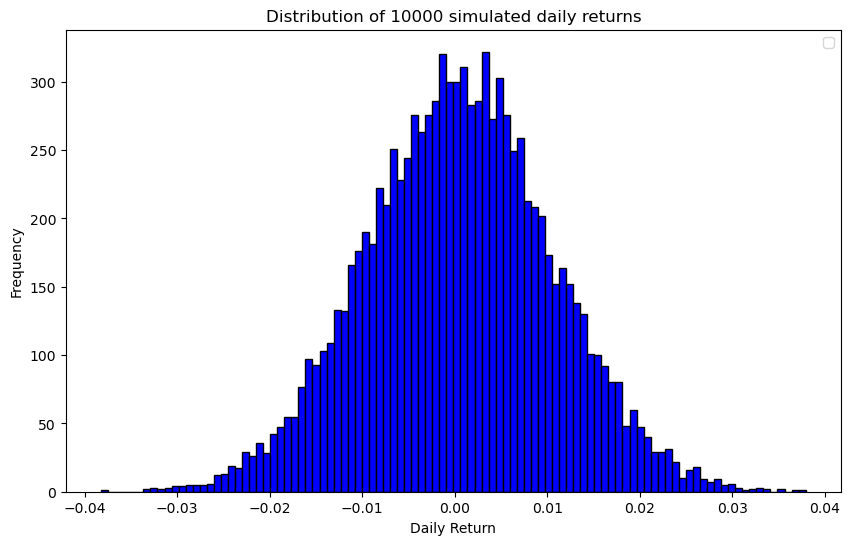

In [19]:
plt.figure(figsize= (10,6))
plt.hist(sim_returns, bins= 100, color= 'blue', edgecolor= 'black')
plt.title('Distribution of 10000 simulated daily returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

On analysis of 5 of the highest market-cap and market share banking company stocks in India, the daily VaR at 95% on a 10000 Monte Carlo simulation = 1.61% 
=> Probability of making a day's loss of more than 1.61% of the investment is 5% => Tail risk: 5%

->This signifies a systemic stability in the sector in the absence of one-off shocks.

->VaR for some of the individual banks is higher than the total portfolio VaR => Diversification benefits.

# EXPECTED SHORTFALL or CVaR

In [21]:
tail_losses = [ret for ret in sim_returns if ret <= var_95]

expected_shortfall_pct = np.mean(tail_losses)
es_in_rs = initial * expected_shortfall_pct

print(f"Expected Shortfall (ES): {expected_shortfall_pct:.2%}")
print(f"Average loss if the threshold is breached: ₹{abs(es_in_rs):,.2f}")


Expected Shortfall (ES): -2.04%
Average loss if the threshold is breached: ₹20,394.17


The gap between VaR and CVaR is evidence fatness in the tail of Indian Banking Sector (Kurtosis).
ES shows that if the "Big Five" breach their normal volatility, the average stopping point is about 2% down.
Gives insight into how much risk capital to hold in preparation for an average bad day. 

# BACKTESTING THE VALUE

In [24]:
estimated_var = -0.0161

test_data = yf.download(tickers, start="2025-01-01", end="2025-12-28")['Close']
test_return = test_data.pct_change().dropna()

actual_returns = (test_return * weights).sum(axis= 1)

exceptions = actual_returns[actual_returns < estimated_var]
num_exceptions = len(exceptions)
total_days = len(actual_returns)
exception_rate = num_exceptions / total_days

print(f"No. of tradig days: {total_days}")
print(f"Total VaR Breaches: {num_exceptions}")
print(f"Actual Exception Rate: {exception_rate:.2%}")

/var/folders/70/13frzt6s3qv7gcdnbf2914xm0000gn/T/ipykernel_3698/2279792350.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download(tickers, start="2025-01-01", end="2025-12-28")['Close']
[*********************100%***********************]  5 of 5 completed

No. of tradig days: 246
Total VaR Breaches: 8
Actual Exception Rate: 3.25%


Relative to the estimated VaR breach limit of 12-13, 8 represents a slight overestimation of risk in VaR. The model is in a comfortable green zone for VaR 95%.